In [9]:
from pathlib import Path
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from data_scripts import *

tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

sns.set_theme(
    # context="talk",
    context="paper",
    # rc={"figure.figsize": (8, 6)},
    palette="bright",
    style="whitegrid",
    rc=tex_fonts,
)

CONVERGED = False
NUM_SIMS = 3
YEAR = 365 * 24 * 60 * 60
USE_SIMULATED_TIME = False

if USE_SIMULATED_TIME:
    X_LABEL = "Simulated time, years"
else:
    X_LABEL = "Time step number"

data = {
    "Coldstart M": load_data("thermal_coldstart_m", n_newest=NUM_SIMS),
    "Warmstart M(S)": load_data("thermal_warmstart_m_s", n_newest=NUM_SIMS),
}

# save_media_path = Path('/dev/null')
save_media_path = None

Loading data:
/home/firedrake/solver_selector/examples/2/performance/thermal_coldstart_m_6.npy
/home/firedrake/solver_selector/examples/2/performance/thermal_coldstart_m_7.npy
/home/firedrake/solver_selector/examples/2/performance/thermal_coldstart_m_8.npy
Loading data:
/home/firedrake/solver_selector/examples/2/performance/thermal_warmstart_m_s_5.npy
/home/firedrake/solver_selector/examples/2/performance/thermal_warmstart_m_s_6.npy
/home/firedrake/solver_selector/examples/2/performance/thermal_warmstart_m_s_7.npy


Coldstart M 98.77329246203105 5.762976169586182
Warmstart M(S) 87.04543749491374 1.334491491317749


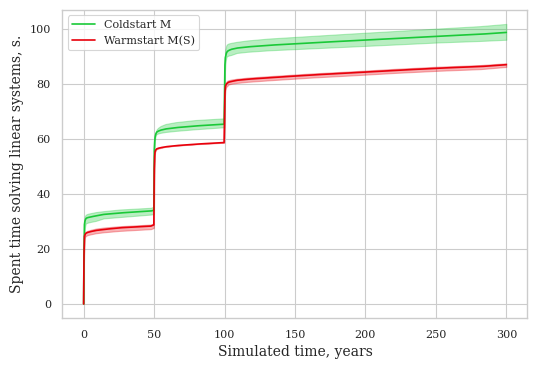

In [10]:
color_iter = 1
best_time = float('inf')
plt.figure(figsize=(6, 4))
for name, values in data.items():
    result = []
    times = []
    color_iter += 1

    for perf in values:
        vals = np.cumsum(
            sum_per_time_step(
                make_solve_linear_system_time(perf, converged=CONVERGED),
                perf,
                converged=CONVERGED,
            )
        )
        result.append(vals)
        if USE_SIMULATED_TIME:
            times.append(make_simulation_time(perf, converged=CONVERGED) / YEAR)
        else:
            times.append(np.arange(len(vals)))

    total = []
    t_end = []
    interp_data_list = []
    x_space = np.linspace(times[0][0], times[0][-1], 1000)
    for time, result in zip(times, result):
        total.append(result[-1])
        t_end.append(time[-1])
        interp_data_list.append(np.interp(x_space, time, result))

    interp_data = np.array(interp_data_list)
    max_ = np.max(interp_data, axis=0)
    min_ = np.min(interp_data, axis=0)
    mean = np.mean(interp_data, axis=0)
    if mean[-1] < best_time:
        best_time = mean[-1]
        best = mean
    plt.fill_between(x_space, min_, max_, color=f"C{color_iter}", alpha=0.3)
    plt.plot(x_space, mean, color=f"C{color_iter}", label=name)
    print(name, np.mean(total), np.max(total) - np.min(total))
    assert np.allclose(t_end, t_end[0], rtol=1e-10)

plt.legend()
plt.xlabel(X_LABEL)
plt.ylabel("Spent time solving linear systems, s.")

if save_media_path is not None:
    plt.savefig(save_media_path / "thermal_performance.pdf", bbox_inches="tight")

Coldstart M 98.77329246203105 5.762976169586182
Warmstart M(S) 87.04543749491374 1.334491491317749


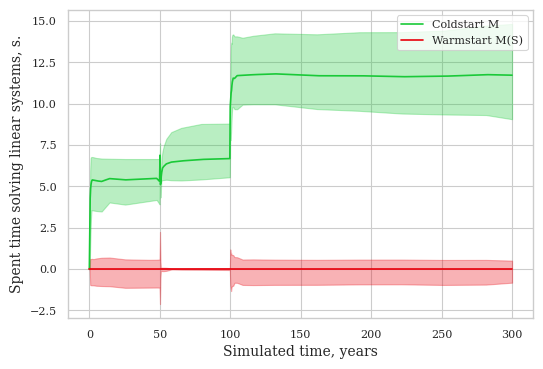

In [11]:
color_iter = 1
plt.figure(figsize=(6, 4))
for name, values in data.items():
    result = []
    times = []
    color_iter += 1

    for perf in values:
        vals = np.cumsum(
            sum_per_time_step(
                make_solve_linear_system_time(perf, converged=CONVERGED),
                perf,
                converged=CONVERGED,
            )
        )
        result.append(vals)
        if USE_SIMULATED_TIME:
            times.append(make_simulation_time(perf, converged=CONVERGED) / YEAR)
        else:
            times.append(np.arange(len(vals)))

    total = []
    t_end = []
    interp_data_list = []
    x_space = np.linspace(times[0][0], times[0][-1], 1000)
    for time, result in zip(times, result):
        total.append(result[-1])
        t_end.append(time[-1])

        interp_data_list.append(np.interp(x_space, time, result))

    interp_data = np.array(interp_data_list)
    max_ = np.max(interp_data, axis=0) - best
    min_ = np.min(interp_data, axis=0) - best
    mean = np.mean(interp_data, axis=0) - best
    plt.fill_between(x_space, min_, max_, color=f"C{color_iter}", alpha=0.3)
    plt.plot(x_space, mean, color=f"C{color_iter}", label=name)
    print(name, np.mean(total), np.max(total) - np.min(total))
    assert np.allclose(t_end, t_end[0], rtol=1e-10)

plt.legend()
plt.xlabel(X_LABEL)
plt.ylabel("Spent time solving linear systems, s.")

if save_media_path is not None:
    plt.savefig(save_media_path / "thermal_performance.pdf", bbox_inches="tight")

Coldstart M (average)


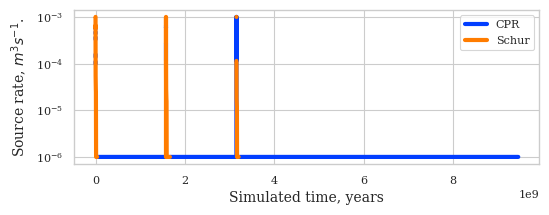

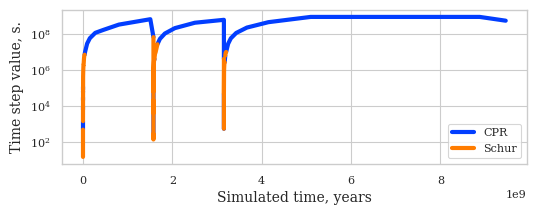

Warmstart M(S) (average)


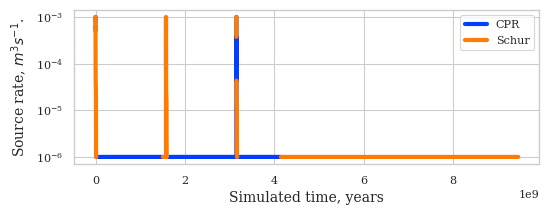

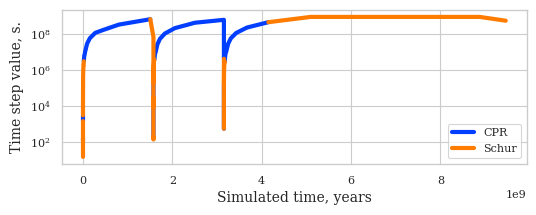

In [12]:
def color_using_schur(x, values, using_schur):
    using_schur = np.array(using_schur).copy()
    using_cpr = ~using_schur
    using_schur[1:] += using_schur[:-1]
    using_schur[:-1] += using_schur[1:]
    lw = 3
    if not USE_SIMULATED_TIME:
        x = np.arange(values.size)
    plt.plot(x, np.where(using_cpr, values, None), label="CPR", linewidth=lw)
    plt.plot(x, np.where(using_schur, values, None), label="Schur", linewidth=lw)
    plt.legend()


def make_using_schur_indices(perf: Sequence[SolverSelectionData], converged=True):
    using_schur = np.array(
        ["schur_cd" in data.config["gmres"]["preconditioner"] for data in perf]
    )
    if converged:
        return using_schur[make_converged_indices(perf)]
    return using_schur


def make_average_decision(values):
    values = np.array(values, dtype=int)
    values = values.sum(axis=0)
    mean = NUM_SIMS / 2
    return values > mean


for name, vals in data.items():
    using_schur_list = []
    time_step_list = []
    inlet_rate_list = []
    sim_time_list = []
    for perf in vals:
        using_schur_list.append(make_using_schur_indices(perf, converged=CONVERGED))
        time_step_list.append(make_time_step(perf, converged=CONVERGED))
        inlet_rate_list.append(make_inlet_rate(perf, converged=CONVERGED))
        sim_time_list.append(make_simulation_time(perf, converged=CONVERGED))

    using_schur_mean = make_average_decision(using_schur_list)

    print(name, "(average)")
    plt.figure(figsize=(6, 2))
    color_using_schur(sim_time_list[0], inlet_rate_list[0], using_schur_mean)
    plt.ylabel("Source rate, $m^3 s^{-1}$.")
    plt.xlabel(X_LABEL)   
    plt.yscale("log")
    if save_media_path is not None:
        plt.savefig(save_media_path / "thermal_source.pdf", bbox_inches="tight")
    plt.show()

    plt.figure(figsize=(6, 2))
    plt.ylabel("Time step value, s.")
    plt.xlabel(X_LABEL)   
    color_using_schur(sim_time_list[0], time_step_list[0], using_schur_mean)
    plt.yscale("log")
    if save_media_path is not None:
        plt.savefig(save_media_path / "thermal_dt.pdf", bbox_inches="tight")
    plt.show()